In [ ]:
import numpy as np 
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Gerekli Kütüphaneler Projeye Ekleniyor

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# *Pnömoni* Veri Kümesini Alınıyor

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Dataset İçeri Aktarılıyor

In [ ]:
train = get_training_data('/content/drive/MyDrive/input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/input/chest-xray-pneumonia/chest_xray/chest_xray/val')

<ipython-input-20-da04b5c45152>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Veri İşleme

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


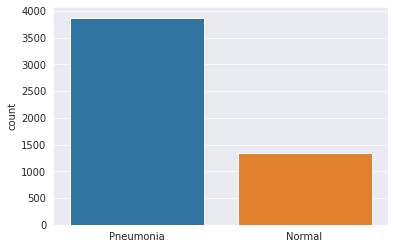

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(l)

Veri seti dengesiz olduğu için Augmentation yapılması gerekiyor ki over fitting olmasın 

#Örnek Görseller

Text(0.5, 1.0, 'NORMAL')

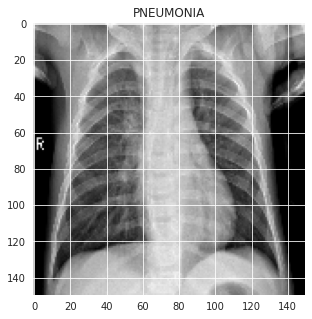

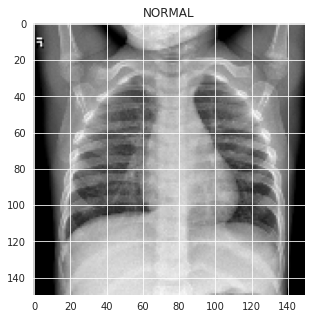

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

#**Future ve Label olarak verileri ayırıyor**

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

print(x_val)
print(y_val)

[array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[17, 19, 19, ..., 18, 13, 14],
       [17, 19, 23, ..., 34, 22, 17],
       [16, 19, 26, ..., 47, 39, 24],
       ...,
       [ 6,  6,  5, ...,  2,  2,  3],
       [ 6,  6,  6, ...,  2,  2,  5],
       [ 7,  6,  6, ...,  2,  2,  4]], dtype=uint8), array([[ 0,  0,  0, ...,  6,  6,  6],
       [ 0,  0,  0, ...,  6,  6,  6],
       [ 0,  0,  0, ...,  6,  6,  6],
       ...,
       [ 3,  3,  3, ..., 61, 18, 10],
       [ 5,  4,  4, ..., 53, 12,  7],
       [ 5,  4,  4, ..., 27, 12, 14]], dtype=uint8), array([[ 10, 255,  24, ...,   0,   0,   0],
       [ 10, 255,  28, ...,   0,   0,   0],
       [  9, 254,  27, ...,   0,   0,   0],
       ...,
       [  2,  10,  21, ...,   0,   0,   2],
       [  0,  10,  22, ...,   0,   0,   0],
       [  0,  10,  21, ...,   0,   0, 

#**Normalizasyon yapılıyor. 0 ile 1 arasında veriler indirgeniyor**

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Veri Büyütme
**Aşırı uyum sorununu önlemek için veri setimizi yapay olarak genişletmemiz gerekiyor. Mevcut veri kümenizi daha da büyütebiliriz. Fikir, varyasyonları yeniden oluşturmak için eğitim verilerini küçük dönüşümlerle değiştirmektir. Etiketi aynı tutarken dizi temsilini değiştiren şekillerde eğitim verilerini değiştiren yaklaşımlar, veri artırma teknikleri olarak bilinir. İnsanların kullandığı bazı popüler büyütmeler, gri tonlamalar, yatay döndürmeler, dikey döndürmeler, rastgele kırpmalar, renk titremeleri, ötelemeler, döndürmeler ve çok daha fazlasıdır. Bu dönüşümlerden sadece birkaçını eğitim verilerimize uygulayarak, eğitim örneklerinin sayısını kolayca ikiye veya üçe katlayabilir ve çok sağlam bir model oluşturabiliriz.**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # veri kümesi üzerinden giriş ortalamasını 0 olarak ayarla
        samplewise_center=False,  # her numune ortalamasını 0 olarak ayarlayın
        featurewise_std_normalization=False,  # girdileri veri kümesinin std'sine göre böl
        samplewise_std_normalization=False,  # her girişi std'sine bölün
        zca_whitening=False,  # ZCA beyazlatma uygulayın
        rotation_range = 30,  # aralıktaki (derece, 0 ila 180) görüntüleri rastgele döndürün
        zoom_range = 0.2, # Görüntüyü rastgele yakınlaştır
        width_shift_range=0.1,  # görüntüleri yatay olarak rastgele kaydırın (toplam genişliğin bir bölümü)
        height_shift_range=0.1,  # görüntüleri dikey olarak rastgele kaydırın (toplam yüksekliğin kesri)
        horizontal_flip = True,  # görüntüleri rastgele çevir
        vertical_flip=False)  # görüntüleri rastgele çevir


datagen.fit(x_train)

Veri artırma için şunu seçtik:
1. Bazı egzersiz görüntülerini rastgele 30 derece döndürdük
2. Bazı egzersiz görüntülerini %20 Rastgele yakınlaştırdık
3. Görüntüleri yatay olarak genişliğin %10'u oranında rastgele kaydırın
4. Görüntüleri dikey olarak yüksekliğin %10'u oranında rastgele kaydırın
5. Resimleri yatay olarak rastgele çevirin.
Modelimiz hazır olduğunda, eğitim veri setini sığdırıyoruz.

# Modeli Eğitiyoruz

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
164/164 [==============================] - 333s 2s/step - loss: 0.5314 - accuracy: 0.8466 - val_loss: 44.4206 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
164/164 [==============================] - 322s 2s/step - loss: 0.2809 - accuracy: 0.8935 - val_loss: 50.1137 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
164/164 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9117
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 [==============================] - 323s 2s/step - loss: 0.2453 - accuracy: 0.9117 - val_loss: 32.3884 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
164/164 [==============================] - 321s 2s/step - loss: 0.1622 - accuracy: 0.9466 - val_loss: 0.7229 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 5/12
164/164 [==============================] - 320s 2s/step - loss: 0.1548 - accuracy: 0.9496 - val_loss: 1.1082 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
164/164 [============================

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 8s 377ms/step - loss: 0.2581 - accuracy: 0.9183
Loss of the model is -  0.2580638825893402
20/20 [==============================] - 8s 376ms/step - loss: 0.2581 - accuracy: 0.9183
Accuracy of the model is -  91.82692170143127 %


# Model Eğitimi Sonrası Analiz

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 8s 377ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.95      0.94       390
   Normal (Class 1)       0.91      0.87      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[369,  21],
       [ 30, 204]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

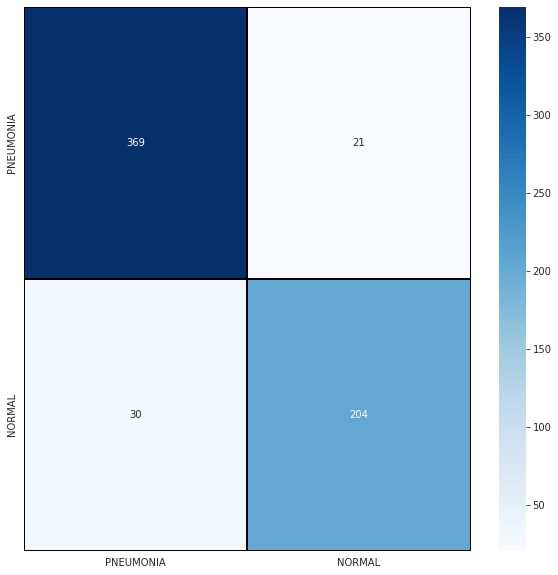

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)